# Validation WOFLs using Ground Truth Data  <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[usgs_ls8c_level2_2]()

Notes:
* This data is confidential at continental level on 26 June 2020.
* This notebook should be run in Collection 2 Read Private Workspace should we need to run the Landsat 8 Collection 2 Sample dataset. 

## Background
The [Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) is a derived product from Landsat 8 satellite observations as part of provisional Landsat Collection 2 surface reflectance and shows water detected for selected areas of Africa.

Individual water classified images are called Water Observation Feature Layers (WOFLs), and are created in a 1-to-1 relationship with the input satellite data. 
Hence there is one WOFL for each satellite dataset processed for the occurrence of water.

## Description
This notebook explains both the structure of the WOFLs, and how you can use WOfS derived product to perform accuracy assessment of the product using ground truth dataset.

The data in a WOFL is stored as a bit field. 
This is a binary number, where each digit of the number is independantly set or not based on the presence (1) or absence (0) of a particular attribute (water, cloud, cloud shadow etc).
In this way, the single decimal value associated to each pixel can provide information on a variety of features of that pixel. 

The notebook demonstrates how to:

1. Load WOFL data for a given location and time period 
2. Inspect the WOFL bit flag information
3. Use the WOFL bit flags to create a binary mask
4. Apply WOFL-based masks to fractional cover dataset 
5. Generating a confusion error matrix for WOFL classification
6. Assessing the accuracy of the classification 
***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

After finishing the analysis, you can modify some values in the "Analysis parameters" cell and re-run the analysis to load WOFLs for a different location or time period.

`Steps to take include:` 
- Load both Landsat8 and Sentinel-2 dataset over part of Africa, Lake Sulunga and calculate NDWI and MNDWI indeces 
- Load WOFS for the same region and compare two results in a quantitive way (Graphs)

### Load packages

In [1]:
%matplotlib inline

import datacube
from datacube.utils import masking, geometry 
import sys
import os
import dask 
import rasterio
import xarray
import glob
import numpy as np
import pandas as pd
import seaborn as sn
import geopandas as gpd
import subprocess as sp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") #this will suppress the warnings for multiple UTM zones in your AOI 

sys.path.append("../Scripts")
from deafrica_plotting import display_map, rgb
from deafrica_spatialtools import xr_rasterize
from deafrica_datahandling import wofs_fuser, mostcommon_crs,load_ard
from rasterio.mask import mask

In [2]:
# prepare environment
%matplotlib inline
import datacube
import geopandas
import rasterio, rasterio.features
import matplotlib.pyplot as plt
import xarray
import numpy as np
import scipy, scipy.ndimage
datacube.config.LocalConfig.db_database = 'wofstest'
datacube.config.LocalConfig.db_hostname = 'agdcstaging-db'
dc = datacube.Datacube()

### Connect to the datacube and list available products 

In [3]:
dc = datacube.Datacube()

In [4]:
!datacube product list 

alos_palsar_mosaic             ALOS/PALSAR and ALOS-2/PALSAR-2 annual mosaic tiles generated for use in the Data Cube - 25m pixel spacing, WGS84. These tiles are derived from the orignal JAXA mosaics with conversion to GeoTIFF.
ga_ls8c_fractional_cover_2     Landsat Fractional Cover based on USGS Scenes
ga_ls8c_gm_2_annual            Annual Geometric Median, Landsat 8
ga_ls8c_wofs_2                 Historic Flood Mapping Water Observations from Space
ga_ls8c_wofs_2_annual_summary  Water Observations from Space Annual Statistics
ga_ls8c_wofs_2_summary         Water Observations from Space Full History Statistics
ga_ls8c_wofs_2_terrain         Water Observations from Space, with terrain mask
ls5_usgs_sr_scene              Landsat 5 USGS Collection 1 Level2 Surface Reflectance USARD. 30m UTM based projection.
ls7_usgs_sr_scene              Landsat 7 USGS Collection 1 Level2 Surface Reflectance USARD. 30m UTM based projection.
ls8_usgs_sr_scene              Landsat 8 USGS Collection 1 High

## Accuracy Assessment for WOFLs

Accuracy assessment includes generating a confusion error matrix for a WOFL binary classification.

The inputs for the assessment are a binary classification of water/non-water output and a shapefile conaining water/non-water points to serve as the "ground-truth" dataset. A confusion error matrix containing overall, producer's and user's accuracy is the output of this analysis. 

Validation points collected by [Collect Earth Online](https://collect.earth/) tool and WOFL layer can be used for calculating the confusion matrix. 

Validation points are the ground truth or actual data while the extracted value for each location from WOFL is the predicted value.
Goals: Calculating confusion matrix for each AEZ and probably whole continent - so we have some flexibility on spatial aggregation. 

* Two extreme cases: 
    - only test wofs classifier and excluding clouds is ok 
    - include terrain so water observed and no terrain is predicted true 

### Analysis parameters
To load WOFL data, we can first create a re-usable query that will define the spatial extent and time period we are interested in, as well as other important parameters that are used to correctly load the data.

In [5]:
#Path to the required dataset for accuracy assessment 
#make sure that validatio points have three columns : location (x,y) and class 
#pred_tif = 'path to the WOFL geotiff layer'
#test the groundtruth with a 6933 EPSG as well (conversion) - how to reproject 
grd_truth = '../Supplementary_data/Validation/CEOSamplePoints_Val.shp'
aez_region = '../Supplementary_data/Validation/simplified_AEZs/AEZs_ExcludeLargeWB_update.shp'
#areas = glob.glob('../../shapes/simplified_AEZs/*.shp') #using aez could be optional 

### Loading Dataset

In [6]:
#Loading collected validation points as ground truth 
#ground_truth = gpd.read_file(grd_truth).to_crs('EPSG:6933')
ground_truth = gpd.read_file(grd_truth)

In [7]:
coords = [(x,y) for x, y in zip(ground_truth.geometry.x, ground_truth.geometry.y)]

In [10]:
buffer = 0.2
#buffer = 15 
#setting up a query dictionay
for i in coords:
    query = {
        'x':(i[0]-buffer,i[0]+buffer),
        'y':(i[1]-buffer,i[1]+buffer),
        'time':('2018-01','2018-12'),
        'resolution':(-30,30)
    }
   # output_crs = mostcommon_crs(dc=dc, product='ga_ls8c_wofs_2',query=query) have everything in 6933 and buffer 15m
    # Load the data from the datacube
    wofls = dc.load(product = "ga_ls8c_wofs_2", output_crs = 'EPSG:6933', group_by="solar_day", fuse_func=wofs_fuser,**query).squeeze()
    # Plot the loaded WOFLs
#     wofl = wofls.isel(time=5)
#     #wofls.water.plot(col="time",col_wrap=3)
#     (wofl.water == 128).plot.imshow()
#     plt.show()

## Create a query 

In [250]:
for key, value in query.items():
    print(key[i], ' : ', value)

x  :  (25.42881575000006, 25.828815750000057)
y  :  (33.491525800000076, 33.89152580000008)
time  :  ('2018-01', '2018-12')
resolution  :  (-30, 30)


In [242]:
#In order to find the available dataset use the following command  
#dc.find_datasets(product='ga_ls8c_wofs_2', **query)
#output_crs = mostcommon_crs(dc=dc, product='ga_ls8c_wofs_2_terrain',query=query) #use the collection 2 one here that should have 2018

## Load WOFL dataset derived from Landsat-8 collection 2 provisional data
To load WOFL data, we can first create a re-usable query as above that will define the spatial extent and time period we are interested in, as well as other important parameters that are used to correctly load the data.

As WOFLs are created scene-by-scene, and some scenes overlap, it's important when loading data to `group_by` solar day, and ensure that the data between scenes is combined correctly by using the WOfS `fuse_func`.
This will merge observations taken on the same day, and ensure that important data isn't lost when overlapping datasets are combined.

In [118]:
# Load the data from the datacube
wofls_terrain = dc.load(product = "ga_ls8c_wofs_2_terrain", output_crs = output_crs, group_by = "solar_day",fuse_func=wofs_fuser, **query)

In [119]:
#In case of comparsion with wofls_terrain over a year 
wofls_summary = dc.load(product = "ga_ls8c_wofs_2_annual_summary", output_crs = output_crs, **query) #no need to add fuse for the annual summary part 

In [120]:
# Plot the loaded WOFLs
#wofls.water.plot(col="time",col_wrap=3)
#plt.show()

In [121]:
wofls = dc.load(product = "ga_ls8c_wofs_2", output_crs = output_crs, **query) #do a masking on wet=True

In [122]:
# Select a set of images in order to the maximum calculation 
wofl = wofls_terrain.isel(time=20)

### Understanding the WOFLs

As mentioned above, WOFLs are stored as a binary number, where each digit of the number is independantly set or not based on the presence (1) or absence (0) of a particular feature. Below is a breakdown of which bits represent which features, along with the decimal value associated with that bit being set to true.

| Attribute | Bit / position   | Decimal value |
|------|------|----|
| No data | 0:   `0-------` or `1-------` | 1|
| Non contiguous | 1:   `-0------` or `-1------` | 2 |
| Sea | 2:   `--0-----` or `--1-----` | 4 |
| Terrain or low solar angle | 3:   `---0----` or `---1----` | 8 |
| High slope | 4:   `----0---` or `----1---` | 16 |
| Cloud shadow | 5:   `-----0--` or `-----1--` | 32 |
| Cloud | 6:   `------0-` or `------1-` | 64 |
| Water | 7:   `-------0` or `-------1` | 128 |


The values in the above plots are the decimal representation of the combination of set flags. 
For example a value of 136 indicates water (128) AND terrain shadow / low solar angle (8) were observed for the pixel,
whereas a value of 144 would indicate water (128) AND high slope (16).

This flag information is available inside the loaded data and can be visualised as below

In [123]:
# Display details of available flags
flags = masking.describe_variable_flags(wofls_terrain)
flags["bits"] = flags["bits"].astype(str)
flags.sort_values(by="bits")

,bits,values,description
nodata,0,"{'0': False, '1': True}",No data
noncontiguous,1,"{'0': False, '1': True}",At least one EO band is missing or saturated
sea,2,"{'0': False, '1': True}",Sea
terrain_or_low_angle,3,"{'0': False, '1': True}",Terrain shadow or low solar angle
high_slope,4,"{'0': False, '1': True}",High slope
cloud_shadow,5,"{'0': False, '1': True}",Cloud shadow
cloud,6,"{'0': False, '1': True}",Cloudy
water_observed,7,"{'0': False, '1': True}",Classified as water by the decision tree
dry,"[7, 6, 5, 4, 3, 1, 0]",{'0': True},Clear and dry
wet,"[7, 6, 5, 4, 3, 1, 0]",{'128': True},Clear and Wet


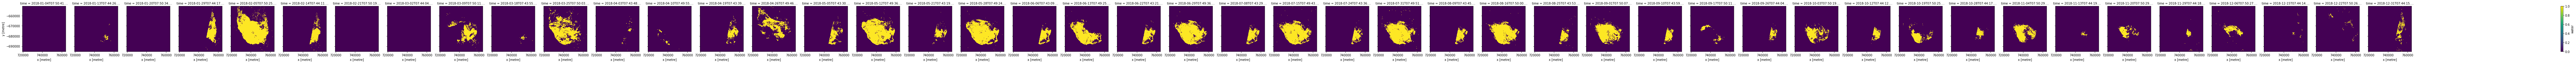

In [124]:
# Show areas flagged as water only (with no other flags set)
(wofls_terrain.water == 128).plot.imshow(col = 'time') #In case that you have time component which  comes with more than one dataset, you need to add col ='time' as an argument to the imshow() 
plt.show()

We can convert the WOFL bit field into a binary array containing True and False values. This allows us to use the WOFL data as a mask that can be applied to other datasets.
The `make_mask` function allows us to create a mask using the flag labels (e.g. "wet" or "dry") rather than the binary numbers we used above. For more details on how to do masking on WOfS, see the [Applying_WOfS_bit_masking](../Frequently_used_code/Applying_WOfS_bitmasking.ipynb) notebook.


In [125]:
wofl_selected = wofls
wofls_mask = {'wet':True}
wofls_output = masking.make_mask(wofl_selected, **wofls_mask)
wofls_output.water.sum(dim='time')

<xarray.DataArray 'water' (y: 1482, x: 1483)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * x            (x) float64 7.195e+05 7.195e+05 ... 7.639e+05 7.64e+05
  * y            (y) float64 -6.507e+05 -6.507e+05 ... -6.951e+05 -6.951e+05
    spatial_ref  int32 32636

In [126]:
wofl_selected = wofls_terrain #.sel(time=slice('2018-06-01', '2018-12-30'))
wet_nocloud = {"water_observed":True, "cloud_shadow":False, "cloud":False, "noncontiguous":False, "nodata":False}
wofl_wetnocloud = masking.make_mask(wofl_selected, **wet_nocloud).astype(int) #using astype(int) will convert the original bool value to integer 
wofl_wet = wofl_wetnocloud.water.sum(dim='time') 
#wofl_wetnocloud.water.max(dim='time') #if =1 means water observed but =0 means other classes that water is available 


In [127]:
dry_nocloud = {"water_observed":False, "cloud_shadow":False, "cloud":False, "noncontiguous":False, "nodata":False}
wofl_drynocloud = masking.make_mask(wofl_selected, **dry_nocloud)
wofl_dry = wofl_drynocloud.water.sum(dim='time')
 
# (dry and nocloud.water.sum(dim=time) + wet and nocloud.water.sum(dim=time)) > 0 #ther is clear observation 
# wetwofl.water.plot()
# plt.show()

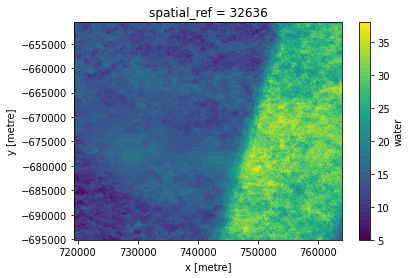

In [128]:
wofl_clear_observations = wofl_dry + wofl_wet
#wofl_clear_observations[10].plot() #this will show the graph of water observation frequency in that location as we move horizontally
wofl_clear_observations.plot() #the image itself 
plt.show()

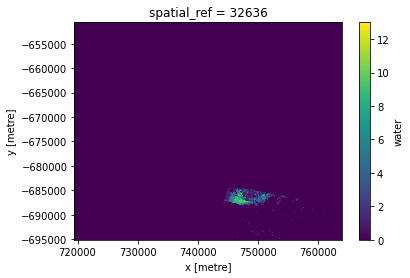

In [129]:
wofl_selected = wofls_summary
#b = wofl_selected.count_wet
c = wofls_output.sum(dim='time')

(c.water - wofl_wet).plot() #try the masking for the layer with the masking that you used for other dataset. 
#(b - wofl_clear_observations).plot(vmin=-1, vmax=1)
#(b - wofl_clear_observations).mean()
#wofl_selected.count_wet.plot()
#wofl_selected.frequency.plot()

In [130]:
# #In case you are interested to load other dataset you can use the load_ard but this command doesnt workd for services like WOfS; however, it does work for fractional cover based on collection2 dataset. 
# output_crs = mostcommon_crs(dc=dc, product='usgs_ls8c_level2_2', query=query)
# # Load available data from Landsat 8 and filter to retain only times
# # with at least 99% good data
# ds = load_ard(dc=dc,
#               products=['usgs_ls8c_level2_2'],
#               output_crs=output_crs,
#               align=(15, 15),
#               **query)

In [273]:
#rename the column class to actual 
ground_truth = ground_truth.rename(columns={'WHAT_IS_TH':'Actual'})
ground_truth.head()

,SAMPLE_ID,LON,LAT,ANALYSES,IMAGERY_TI,SENTINEL2M,PL_PLOTID,ENTER_MONT,COMMENTS,Actual,geometry
0,510677376,11.113083,36.894297,1,Sentinel 2,2018 - 2018,1,1-Dec,NA,Open water - marine,POINT (11.11308 36.89430)
1,510677377,5.688374,36.050819,1,Sentinel 2,2018 - 2018,2,"1,2,3,4,5,6","For October to December, there area was green.",Open water - freshwater,POINT (5.68837 36.05082)
2,510677378,15.279478,32.305943,1,Sentinel 2,2018 - 2018,3,1-Dec,NA,Open water - marine,POINT (15.27948 32.30594)
3,510677379,33.691526,25.628816,1,Sentinel 2,2018 - 2018,4,0,NA,Barren (Bare soil / Rocky Land),POINT (33.69153 25.62882)


In [274]:
#An optional stage, if there is a need to read the AEZ region file and clip the validation points 
aez=gpd.read_file(aez_region).to_crs('EPSG:6933')

In [ ]:
#Reading the WOFL layer 
prediction = rasterio.open(pred_tif)

In [37]:
# clip validation points to region (optional)
ground_truth = gpd.overlay(ground_truth,aez,how='intersection')

### Extract a list of coordinate values 

In [38]:
coords = [(x,y) for x, y in zip(ground_truth.geometry.x, ground_truth.geometry.y)]

#### Sample the WOFL layer at the ground truth coordinate

In [39]:
# Sample the raster at every point location and store values in DataFrame
ground_truth['Prediction'] = [int(x[0]) for x in prediction.sample(coords)]
ground_truth.head()

NameError: name 'prediction' is not defined

In [ ]:
confusion_matrix = pd.crosstab(ground_truth['Actual'],
                               ground_truth['Prediction'],
                               rownames=['Actual'],
                               colnames=['Prediction'],
                               margins=True)
confusion_matrix

In [ ]:
#get the training data and covert it to shapefile using the get_training data function in the scripts 

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** January 2020

**Compatible datacube version:** 

# The following stages is for Sentinel-2AB dataset

## Create a query and load Sentinel-2AB satellite data 

To demonstrate how to compute a remote sensing index, we first need to load in a time series of satellite data for an area. We will use data from Sentinel-2A satellite. 

In [73]:
lat, lon =  -6.083 ,35.184 #location of lake Sulunga, Tanzania 
buffer = 0.2

# Create a reusable query
query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    'time': ('2019-05', '2020-05'),
    'resolution':(-10,10),
    'group_by':'solar_day',
    'cloud_cover': [0,90]
}

# Identify the most common projection system in the input query 
output_crs = mostcommon_crs(dc=dc, product='s2_l2a', query=query)
# Load available data from Landsat 8 and filter to retain only times
# with at least 99% good data
ds = load_ard(dc=dc, 
              products=['s2_l2a'], 
              output_crs=output_crs,
              min_gooddata = 0.99, 
              measurements = ['red','green','blue','nir_1','swir_1'],
              dask_chunks={},
              **query)

#automatically detect the number of cpus
ncpus=int(float(sp.getoutput('env | grep CPU')[-3:]))

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 7 out of 122 time steps with at least 99.0% good quality pixels
Applying pixel quality/cloud mask
Returning 7 time steps as a dask array


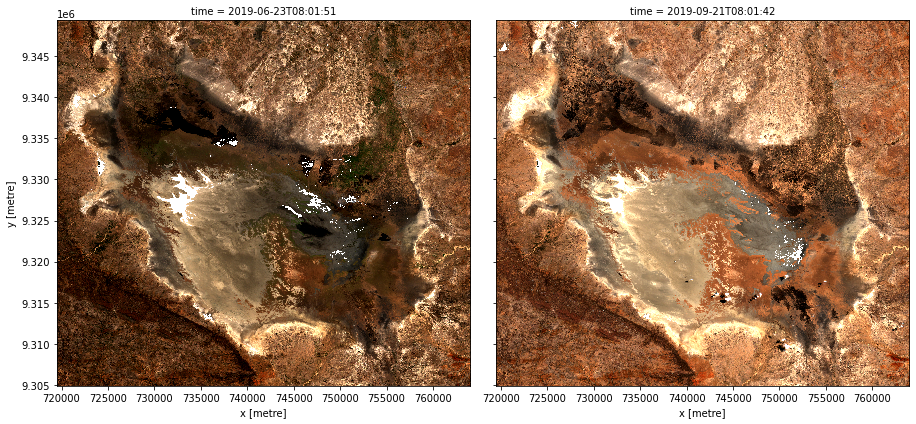

In [74]:
rgb(ds, bands = ['red','green','blue'], index=[0,6])

In [16]:
print(datacube.__version__)

1.7+253.ga031f3f4.dirty


## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)